In [13]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

# List filer og mapper i din Google Drive rodmappe
drive_path = "/content/drive/My Drive/Data"
print(os.listdir(drive_path))

['cifake_radial_profiles_train.csv']


# Data loader
We start by splitting the data up into training(0.7), validation(0.15) and test (0.15) data

In [16]:
print('Start Data_loader')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import ast
import torch
from google.colab import drive
import matplotlib.pyplot as plt


# Filsti til CSV-filen
df = pd.read_csv("/content/drive/My Drive/Data/cifake_radial_profiles_train.csv")

# Omform de strenge til lister (brug ast.literal_eval for at sikre korrekt parsing af lister)
label_encoder = LabelEncoder()

y =torch.tensor(label_encoder.fit_transform(df.iloc[:,0].values.tolist()))

# Første split: træning og midlertidigt datasæt (validering + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    torch.tensor(df.iloc[:,1:].map(ast.literal_eval).values.tolist()), torch.tensor(label_encoder.fit_transform(df.iloc[:,0].values.tolist())), test_size=0.3, stratify=torch.tensor(label_encoder.fit_transform(df.iloc[:,0].values.tolist())), random_state=42
)

# Andet split: validering og test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Funktion til at skabe dataloaders
def create_dataloaders(batch_size, X_train, y_train, X_val, y_val):
    # Beregn batch størrelser
    train_batch_size = 2 ** batch_size
    val_batch_size = 2 ** (batch_size - 1)

    # Skab Dataset objekter
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)

    # Skab DataLoader objekter
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

    return train_loader, val_loader


print('End Data_loader')

Start Data_loader
End Data_loader


# Defining the structure of the models
FFNN dim: 474 -> 2**7 -> 2**3 -> 1

CNN channels: 1 -> 64 -> 128 -> 256 dim: ????? needs more researching

RNN dim and channels needs more recearsh in this area

In [ ]:
print('Start modeller')

import torch
import torch.nn as nn
import torch.nn.functional as F


class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        # Definer vægte og biaser med bedre initialisering
        self.W_1 = nn.Linear(474, 2**7)  # Skift til nn.Linear for bedre initialisering
        self.W_2 = nn.Linear(2**7, 2**3)
        self.W_3 = nn.Linear(2**3, 1)
        # Batch Normalization og Dropout
        self.batch_norm_1 = nn.BatchNorm1d(2**7)
        self.batch_norm_2 = nn.BatchNorm1d(2**3)
        self.dropout = nn.Dropout(p=0.5)
        # Initialisering af vægte (kan tilpasses)
        self._initialize_weights()
    def _initialize_weights(self):
        # He-initialisering for lineære lag
        nn.init.kaiming_normal_(self.W_1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.W_2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.xavier_normal_(self.W_3.weight)  # Xavier initialization for output lag
        nn.init.zeros_(self.W_1.bias)
        nn.init.zeros_(self.W_2.bias)
        nn.init.zeros_(self.W_3.bias)
    def forward(self, x):
        # Flad inputtet ud til (batch_size, 474)
        x = x.view(x.size(0), -1)  # (batch, 3, 158) bliver til (batch, 474)
        # Første lag: Lineær transformation, batch normalisering og ReLU aktivering
        x = self.W_1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        # Dropout for regularisering
        x = self.dropout(x)
        # Andet lag: Lineær transformation, batch normalisering og ReLU aktivering
        x = self.W_2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        # Dropout igen
        x = self.dropout(x)
        # Output lag: Lineær transformation og sigmoid aktivering for binær klassifikation
        x = self.W_3(x)
        x = torch.sigmoid(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Konvolutionsblok 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 9), stride=1, padding=(0, 4)),  # 1 -> 64 kanaler
            nn.BatchNorm2d(64),  # Stabilisering
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))  # Reducerer dimensionerne
        )

        # Konvolutionsblok 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 5), stride=1, padding=(0, 2)),  # 64 -> 128 kanaler
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))  # Yderligere reduktion af dimensionerne
        )

        # Konvolutionsblok 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 3), stride=1, padding=(0, 1)),  # 128 -> 256 kanaler
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Global gennemsnitspooling for at aggregere over højden og bredden
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Samler til én værdi pr. kanal

        # Fully connected blok
        self.fc_block = nn.Sequential(
            nn.Linear(256, 128),  # 256 kanaler fra global pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regulering
            nn.Linear(128, 1)  # Output én klasse
        )

    def forward(self, x):
        # Input forventes som (batch_size, channels, height, width)
        x = x.unsqueeze(1)  # Tilføjer en kanal-dimension: (B, 1, 3, 158)
        x = self.conv_block1(x)  # Passerer gennem den første konvolutionsblok
        x = self.conv_block2(x)  # Passerer gennem den anden konvolutionsblok
        x = self.conv_block3(x)  # Passerer gennem den tredje konvolutionsblok
        x = self.global_pool(x)  # Global gennemsnitspooling
        x = x.squeeze(-1).squeeze(-1)  # Fjern de sidste to dimensioner: (B, 256, 1, 1) -> (B, 256)
        x = self.fc_block(x)  # Passerer gennem fully connected blokken
        return torch.sigmoid(x)  # Output mellem 0 og 1 for binær klassifikation

class RNN(nn.Module):

    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size=158,  # Juster input_size til 158
                          hidden_size=128,
                          num_layers=2,
                          batch_first=True,
                          dropout=0.2)  # Dropout for at forhindre overfitting

        # Batch Normalization (valgfrit, men kan hjælpe med stabilisering)
        self.bn = nn.BatchNorm1d(128)

        # Et fuldt forbundet lag til at give det binære output
        self.fc = nn.Linear(128, 1)

        # Sigmoid aktivering for binær klassifikation
        # Vi bruger ikke Sigmoid her, da BCEWithLogitsLoss håndterer det
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        RNN_out, _ = self.rnn(x)

        # Vi tager kun den sidste skjulte tilstand (output fra den sidste tid)
        last_hidden_state = RNN_out[:, -1, :]

        # Batch Normalization (kan forbedre konvergens)
        last_hidden_state = self.bn(last_hidden_state)

        # Fuld forbindelse og sigmoid for binært output
        out = self.fc(last_hidden_state)
        out = self.sigmoid(out)  # Vi bruger sigmoid her, men alternativt kan BCEWithLogitsLoss bruges

        return out

print('End modeller')

Start modeller
End modeller


# Training and validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Kontrollér om GPU er tilgængelig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the batch size and create dataloaders
batch_size = 9  # 2**x
train_loader, val_loader = create_dataloaders(batch_size, X_train, y_train, X_val, y_val)

# Initialize models
model1 = FFNN().to(device)
model2 = CNN().to(device)
model3 = RNN().to(device)

# Define loss function and optimizers
criterion = nn.L1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Training loop with validation
epochs = 10  # Set the number of epochs

# Track losses
train_losses = {"model1": [], "model2": [], "model3": []}
val_losses = {"model1": [], "model2": [], "model3": []}

print('Starting training')

for epoch in range(epochs):
    # Training phase
    model1.train()
    model2.train()
    model3.train()

    for X_batch, y_batch in train_loader:
        # Flyt data til GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

        # Zero the gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        # Forward pass
        output1 = model1(X_batch).squeeze().float()
        output2 = model2(X_batch).squeeze().float()
        output3 = model3(X_batch).squeeze().float()

        # Calculate losses
        loss1 = criterion(output1, y_batch)
        loss2 = criterion(output2, y_batch)
        loss3 = criterion(output3, y_batch)

        # Backward pass and optimize
        loss1.backward()
        optimizer1.step()

        loss2.backward()
        optimizer2.step()

        loss3.backward()
        optimizer3.step()

        # Append training losses
        train_losses["model1"].append(loss1.item())
        train_losses["model2"].append(loss2.item())
        train_losses["model3"].append(loss3.item())

    # Validation phase
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Flyt data til GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

            # Forward pass
            output1 = model1(X_batch).squeeze().float()
            output2 = model2(X_batch).squeeze().float()
            output3 = model3(X_batch).squeeze().float()

            # Calculate validation losses
            loss1 = criterion(output1, y_batch)
            loss2 = criterion(output2, y_batch)
            loss3 = criterion(output3, y_batch)

            # Append validation losses
            val_losses["model1"].append(loss1.item())
            val_losses["model2"].append(loss2.item())
            val_losses["model3"].append(loss3.item())

    print(f'Epoch {epoch + 1}/{epochs} - Training Losses: '
          f'Model1={train_losses["model1"][-1]:.4f}, '
          f'Model2={train_losses["model2"][-1]:.4f}, '
          f'Model3={train_losses["model3"][-1]:.4f} | '
          f'Validation Losses: '
          f'Model1={val_losses["model1"][-1]:.4f}, '
          f'Model2={val_losses["model2"][-1]:.4f}, '
          f'Model3={val_losses["model3"][-1]:.4f}')

print('Training and validation complete')


Using device: cuda
Starting training
Epoch 1/10 - Training Losses: Model1=0.3966, Model2=0.1895, Model3=0.3911 | Validation Losses: Model1=0.3493, Model2=0.4474, Model3=0.3504
Epoch 2/10 - Training Losses: Model1=0.3562, Model2=0.1855, Model3=0.3650 | Validation Losses: Model1=0.2925, Model2=0.2151, Model3=0.3373
Epoch 3/10 - Training Losses: Model1=0.2689, Model2=0.2037, Model3=0.4002 | Validation Losses: Model1=0.2400, Model2=0.1673, Model3=0.3122
Epoch 4/10 - Training Losses: Model1=0.2354, Model2=0.1923, Model3=0.3864 | Validation Losses: Model1=0.1877, Model2=0.4320, Model3=0.3595
Epoch 5/10 - Training Losses: Model1=0.2058, Model2=0.1722, Model3=0.3124 | Validation Losses: Model1=0.1846, Model2=0.4245, Model3=0.4250
Epoch 6/10 - Training Losses: Model1=0.2347, Model2=0.2029, Model3=0.3257 | Validation Losses: Model1=0.1798, Model2=0.4469, Model3=0.3901
Epoch 7/10 - Training Losses: Model1=0.2248, Model2=0.1783, Model3=0.4153 | Validation Losses: Model1=0.2021, Model2=0.2170, Mode

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_losses["model1"], label='FFNN - Training', color='blue')
plt.plot(train_losses["model2"], label='CNN - Training', color='green')
plt.plot(train_losses["model3"], label='RNN - Training', color='red')
plt.xlabel("Ste")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

NameError: name 'plt' is not defined

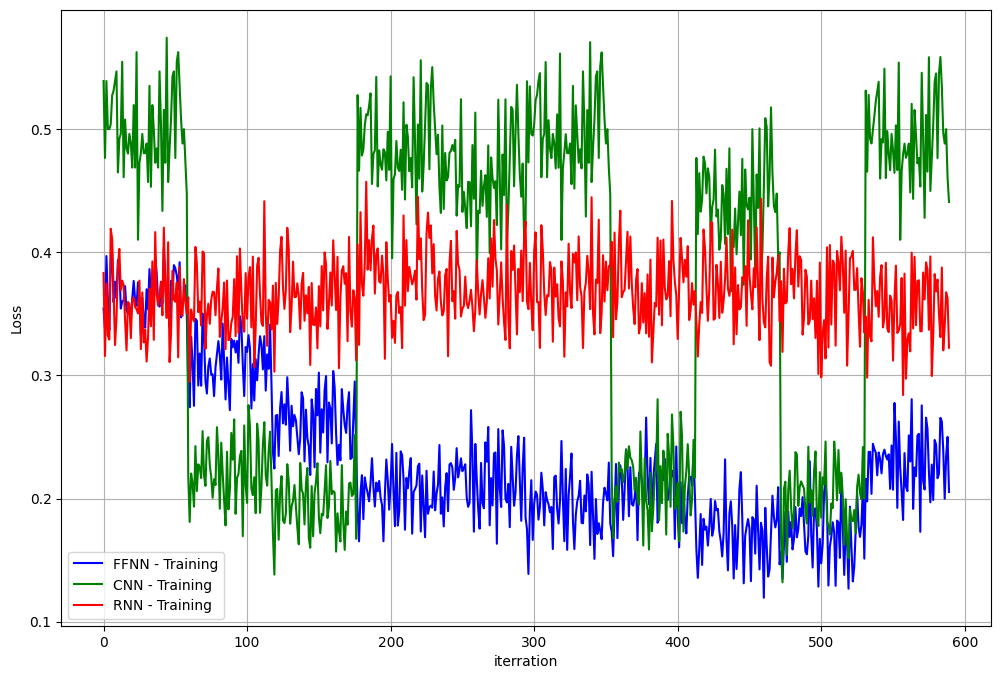

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(val_losses["model1"], label='FFNN - Training', color='blue')
plt.plot(val_losses["model2"], label='CNN - Training', color='green')
plt.plot(val_losses["model3"], label='RNN - Training', color='red')
plt.xlabel("iterration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()